# Goal of the notebook:

To apply Annealed Langevin Posterior Sampling algorithm using energy model for MRI inverse problem 

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import pickle
import torch.nn as nn   
import os

device=torch.device('cuda:0')

 
from dataclasses import dataclass
import dnnlib


from sense_new import sense_v1
from utils import *

# load model

In [2]:
with dnnlib.util.open_url("./models/Full_fastmri_score_model.pkl") as f:
    net0 = pickle.load(f)["ema"].to(device)

net = Denoiser(net0).to(device)

net_path = "./models/netbest_model_epoch_26.pt"
state = torch.load(net_path, map_location=device)
net.load_state_dict(state)
net.eval()

Denoiser(
  (net): EDMPrecond(
    (model): SongUNet(
      (map_noise): PositionalEmbedding()
      (map_label): Linear()
      (map_augment): Linear()
      (map_layer0): Linear()
      (map_layer1): Linear()
      (enc): ModuleDict(
        (384x384_conv): Conv2d()
        (384x384_block0): UNetBlock(
          (norm0): GroupNorm()
          (conv0): Conv2d()
          (affine): Linear()
          (norm1): GroupNorm()
          (conv1): Conv2d()
        )
        (384x384_block1): UNetBlock(
          (norm0): GroupNorm()
          (conv0): Conv2d()
          (affine): Linear()
          (norm1): GroupNorm()
          (conv1): Conv2d()
        )
        (192x192_down): UNetBlock(
          (norm0): GroupNorm()
          (conv0): Conv2d()
          (affine): Linear()
          (norm1): GroupNorm()
          (conv1): Conv2d()
          (skip): Conv2d()
        )
        (192x192_block0): UNetBlock(
          (norm0): GroupNorm()
          (conv0): Conv2d()
          (affine): Linear()

# load data

In [5]:
processed_dir = "./subset_test_data"
pt_files = [f for f in os.listdir(processed_dir) if f.endswith(".pt")]


loaded_data =[]
path = os.path.join(processed_dir,pt_files[0] )
loaded_data.append(torch.load(path, map_location="cpu") ) # {"x": ..., "b_hat": ..., "csm": ...}



mask_np = np.load('acc8_1D_mask.npy').astype(np.complex64)
mask = torch.tensor(mask_np).unsqueeze(0).unsqueeze(0)  
tstMask = mask.to(device)


org = loaded_data[0]["x"].to(device, dtype=torch.complex64)
b = loaded_data[0]["b_hat"].to(device)
tstCsm = loaded_data[0]["csm"].to(device)
b_hat = b * tstMask 

# ALPS parameters

In [6]:
@dataclass
class Options:
    num_steps: int = 50
    sigma_max: float = 5
    sigma_min: float = 0.002
    rho: float = 7
    K: int = 3
    inference_std: float=0.006
opts = Options()



batch=1
class_labels = None
if getattr(net0, "label_dim", 0):
    row0 = torch.eye(net0.label_dim, device=device)[0]   
    class_labels = row0.unsqueeze(0).expand(batch, -1)         
    class_labels = class_labels.contiguous().float()


# ALPS algorithm

/tmp/ipykernel_1700136/748426898.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax[i].imshow(torch.rot90(torch.rot90(torch.tensor((xarray[i,0])))).abs().detach().cpu(),cmap='gray',vmax=0.6); ax[i].axis('off')


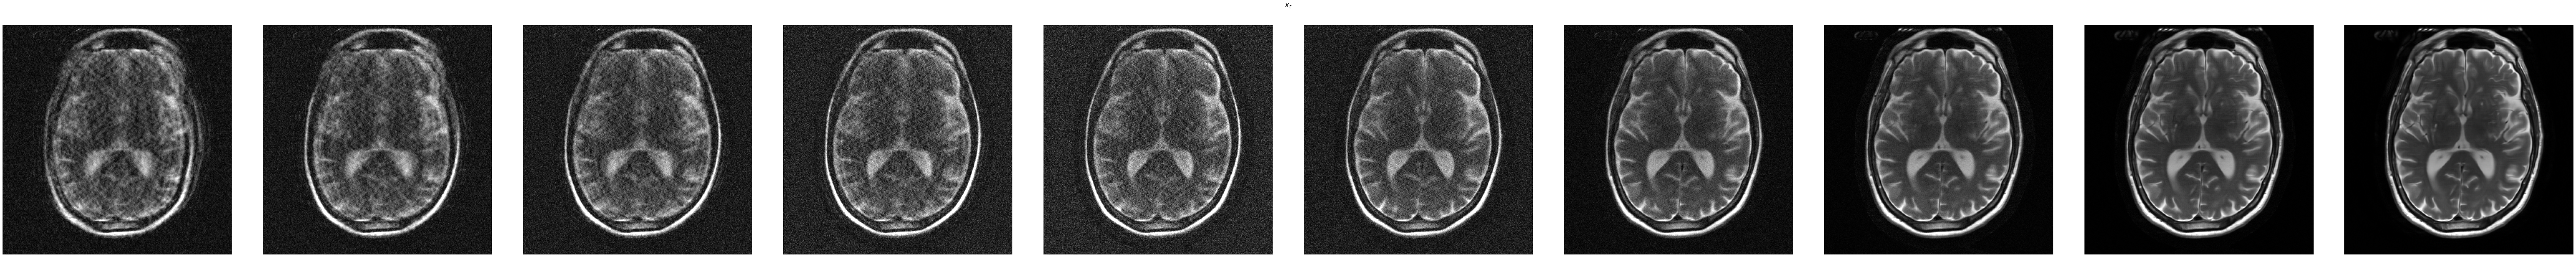

In [11]:




A= sense_v1(10)
x,xarray = ALPS(opts,A, net, b_hat,tstCsm,tstMask,class_labels, isALPS=True, storeIntermediate=True)
if(xarray.shape[0]>10):
    step = xarray.shape[0]//10
    xarray = xarray[::step]
fig, ax = plt.subplots(1,xarray.shape[0], figsize=(xarray.shape[0]*10,10))   
#sample evolution
for i in range(xarray.shape[0]):
    ax[i].imshow(torch.rot90(torch.rot90(torch.tensor((xarray[i,0])))).abs().detach().cpu(),cmap='gray',vmax=0.6); ax[i].axis('off')


        
            
        
          

   

/tmp/ipykernel_1700136/702454265.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.rot90(torch.rot90(torch.tensor((org[0,0])))).abs().detach().cpu(),cmap='gray',vmax=0.6)
/tmp/ipykernel_1700136/702454265.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.rot90(torch.rot90(torch.tensor((x[0,0])))).abs().detach().cpu(),cmap='gray',vmax=0.6)


Text(0.5, 1.0, 'ALPS sample')

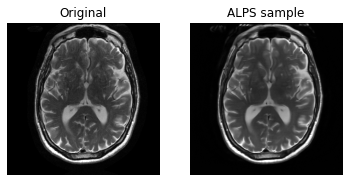

In [13]:
plt.subplot(121)
plt.imshow(torch.rot90(torch.rot90(torch.tensor((org[0,0])))).abs().detach().cpu(),cmap='gray',vmax=0.6)
plt.title('Original')
plt.axis('off')
plt.subplot(122)
plt.imshow(torch.rot90(torch.rot90(torch.tensor((x[0,0])))).abs().detach().cpu(),cmap='gray',vmax=0.6)
plt.axis('off')
plt.title('ALPS sample')